In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import string
import unidecode
import time, math
import random
import torch

# Used by the model
import torch
import torch.nn as nn
from torch.autograd import Variable


# Prevent kernel from dying
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

/Users/faustotnc/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Loading The Data

In [2]:
# Reads the data
labeledPfd = pd.read_csv("./datasets/LabeledPoetryFoundationPoems.csv")


# Filters the poems by category
def get_poems_by_category(category):
    data = []
    for poem, emotion in zip(labeledPfd["poem"], labeledPfd["emotion"]):
        if emotion == category:
            data.append(poem)
    return data


# Gets the poems in each category
poems = {
    "joy": get_poems_by_category("joy"),
    "trust": get_poems_by_category("trust"),
    "sadness": get_poems_by_category("sadness"),
    "anticipation": get_poems_by_category("anticipation"),
    "fear": get_poems_by_category("fear"),
    "anger": get_poems_by_category("anger"),
    "disgust": get_poems_by_category("disgust"),
    "surprise": get_poems_by_category("surprise")
}

# Processing the Data

In [3]:
# Training with only 100 poems.
# When trying to train with the entrie dataset (~4000 poems)
# the kernel dies before completing the first epoch.
text = list(poems["joy"])

def joinStrings(text):
    return '\n'.join(string for string in text)
text = joinStrings(text)

# Clean the data
# Removes punctuation from the dataset
clean_data = [word for word in nltk.word_tokenize(text) if word.isalnum()]
print("Number of tokens:", len(clean_data)) # Number of tokens
print(clean_data[:10])

# Extracts the vocabulary
vocab = set(clean_data)
voc_len = len(vocab)

# Encodes the position of each word in the vocabulary
word_to_ix = {word: i for i, word in enumerate(vocab)}

# Generates trigram word embeddings
# with the data. For the sentence:
# "I party with my friends on the weekends"
# "with", and "my" will be the context for
# the word "friends". An example is printed bellow
embeddings = [ ([trigram[0], trigram[1]], trigram[2]) for trigram in ngrams(clean_data, 3)]
num_embeddings = len(embeddings)
print(embeddings[:3])

Number of tokens: 1137379
['Invisible', 'fish', 'swim', 'this', 'ghost', 'ocean', 'now', 'described', 'by', 'waves']
[(['Invisible', 'fish'], 'swim'), (['fish', 'swim'], 'this'), (['swim', 'this'], 'ghost')]


# Generating Input-Output Pairs

In [4]:
# Creates the input and target vectors
in_out_pairs = {
    "joy": {"inp": [], "tar": []},
    "trust": {"inp": [], "tar": []},
    "sadness": {"inp": [], "tar": []},
    "anticipation": {"inp": [], "tar": []},
    "fear": {"inp": [], "tar": []},
    "anger": {"inp": [], "tar": []},
    "disgust": {"inp": [], "tar": []},
    "surprise": {"inp": [], "tar": []}
}

# Only generates input-output pairs for the "Joy" dataset
for context, target in embeddings:
    # 2dim tensor with the positions of the context letters
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    in_out_pairs["joy"]["inp"].append(context_idxs)
    
    # 1dim tensor with the position of the target letter
    targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
    in_out_pairs["joy"]["tar"].append(targ)

# The Recurrent Neural Network (GRU)

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        # We are using the GRU method to train the model
        self.gru = nn.GRU(
            hidden_size * 2,
            hidden_size,
            n_layers,
            batch_first = True, # x: (num_embeddings, context_size, input_size)
            bidirectional = False
        )
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_vect, hidden):
        input_vect = self.encoder(input_vect.view(1, -1)) # flattens the input vector
        output, hidden = self.gru(input_vect.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# The Model & Hyperparameters

In [6]:
n_epochs = 10
print_every = 1
plot_every = 1
hidden_size = 120 # 120 nodes on each hidden layer 
n_layers = 2 # two hidden layers
lr = 0.01 # learning rate
batch_size = 48

model = RNN(voc_len, hidden_size, voc_len, n_layers)
model_optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# The Trainer Function

In [11]:
# Trains the model with the data for
# the equivalent of 1 epoch
def train(inp, target):
    hidden = model.init_hidden()
    
    # Initializes the gradients and the loss
    model.zero_grad()
    loss = 0
    
    # Trains the neural network over all
    # the character embeddings
    sample_data = random.sample(list(zip(inp, tar)), batch_size)
    index = 0
    for input_sample, output_sample in sample_data:
        # Prints the progress every 1000th embedding
        print(index, "out of", len(sample_data), end="\r")
        
        # The model taken in a context tensor, and
        # the previous hidden state to predict an
        # output, and compute a new hidden state
        output, hidden = model.forward(input_sample, hidden)
        
        # The loss is computed using the predicted output
        # and the target (expected output)
        loss += criterion(output, output_sample)
        
        # Increments the index
        index += 1

    # Propagates the loss backwards
    # through the network
    print("Performing back-propagation...")
    loss.backward()
    model_optimizer.step()

    # Returns the loss of the network
    return loss.data.item() / num_embeddings

## Training the Model

In [12]:
total_time_start = time.time()
all_losses = []
loss_avg = 0


# Converts the execution time
# to a human-readible format
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Trains the model.
# n_epochs determines how many times we
# will show the same data to the network.
for epoch in range(1, n_epochs + 1):
    start = time.time()
    
    # Trains the model for the
    # current epoch
    inp = in_out_pairs["joy"]["inp"]
    tar = in_out_pairs["joy"]["tar"]
    loss = train(inp, tar)       
    loss_avg += loss

    # Logs out the epoch execution time
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    # Saves the epoch execution time for later plotting
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
# Prints the total time taken by training the model
print("\nTotal Training Time:", time_since(total_time_start))

Performing back-propagation...
 2s (1 10%) 0.0005]
Performing back-propagation...
 2s (2 20%) 0.0005]
Performing back-propagation...
 1s (3 30%) 0.0005]
Performing back-propagation...
 2s (4 40%) 0.0005]
Performing back-propagation...
 2s (5 50%) 0.0004]
Performing back-propagation...
 2s (6 60%) 0.0004]
Performing back-propagation...
 2s (7 70%) 0.0004]
Performing back-propagation...
 2s (8 80%) 0.0004]
Performing back-propagation...
 1s (9 90%) 0.0004]
Performing back-propagation...
 2s (10 100%) 0.0004]

Total Training Time: 0m 24s


# Plotting the Model's Loss

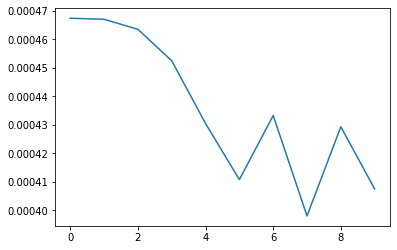

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# The Poem Generator Function

In [14]:
def generate(prime_str='I love', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()

    for p in range(predict_len):
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long)
        inp = prime_input[-2:] #last two words as input
        output, hidden = model.forward(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word

    return prime_str

## Generating Poems

In [15]:
generated_poem = generate()
print(generated_poem)

I love neighbors meadowsweet become of s s s that the on in may in the and my of Hath from crepe a evangelistsHow or of Mahomet in of from of the then a s I of the of it with the in in the of and Sweeney in in coldness s s or That do of the in in That of of in And of of of the of And Excites I in a s of trees And pleasure And gynecologists hope s of of of that dust I from And in and in night higher or with and of into
